In [1]:
#import
import sys

import pandas as pd
import numpy as np
from scipy import special
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm

sys.path.append('../')
from pyopt.util import fft, ifft, save_pickle, load_pickle, sampling_signal

In [3]:
def load_signal(signal_info, trans_condition, n, Lmax):
    if signal_info['signal_type'] == 'prbs':
        return load_prbs(signal_info, trans_condition, n, Lmax)
    elif signal_info['signal_type'] == 'random':
        return load_random(signal_info, trans_condition, n, Lmax)
    elif signal_info['signal_type'] == 'image':
        return load_image(signal_info, trans_condition, n, Lmax)

In [4]:
def load_prbs(signal_info, trans_condition, n, Lmax):
    N = signal_info['N']
    itr = signal_info['itr']
    signal_condition = 'N=='+str(N)+'&itr=='+str(itr)
    signal_list = [N, itr] + [None] * 6
    
    # prbs.csvをpandasで読み込む
    t_df_dir = '../data/input/'
    t_df = pd.read_csv(t_df_dir + 'prbs.csv', index_col=0)
    
    # prbs.csvにおいて、指定した伝送条件を見たす行を抜き出す
    t_query = t_df.query(signal_condition + '&' + trans_condition)
    
    # if prbs.csvに指定した伝送条件がない or Lmax以外は満たすがLmaxだけ指定した条件未満: 何もしない if ある: 続ける
    if len(t_query) == 0 or t_query.iloc[0]['Lmax'] < Lmax:
        print('指定された伝送条件の信号が存在しません')
        return
    else:
        # 伝送信号を学習データに整形する
        sgnl = load_pickle(t_query.iloc[0]['data_path'])
        return sgnl

In [5]:
def load_random(signal_info, trans_condition, n, Lmax):
    seed = signal_info['seed']
    bit_num = signal_info['bit_num']
    signal_condition = 'seed=='+str(seed)+'&bit_num=='+str(bit_num)
    signal_list = [None] * 2 + [seed, bit_num] + [None] * 4
    
    # random.csvをpandasで読み込む
    t_df_dir = '../data/input/'
    t_df = pd.read_csv(t_df_dir + 'random.csv', index_col=0)
    
    # random.csvにおいて、指定した伝送条件を見たす行を抜き出す
    t_query = t_df.query(signal_condition + '&' + trans_condition)
    
    # if random.csvに指定した伝送条件がない or Lmax以外は満たすがLmaxだけ指定した条件未満: 何もしない if ある: 続ける
    if len(t_query) == 0 or t_query.iloc[0]['Lmax'] < Lmax:
        print('指定された伝送条件の信号が存在しません')
        return
    else:
        # 伝送信号を学習データに整形する
        sgnl = load_pickle(t_query.iloc[0]['data_path'])
        return sgnl

In [6]:
def load_image(signal_info, trans_condition, n, Lmax):
    target_dir = signal_info['target_dir']
    step = signal_info['step']
    image_number = signal_info['image_number']
    image_number_split = image_number.split(', ')
    ebtb = signal_info['ebtb']
    signal_condition = 'target_dir=="'+str(target_dir)+'"&step=='+str(step)+'&image_number=="'+image_number+'"&ebtb=='+str(ebtb)
    signal_list = [None] * 4 + [target_dir, step, image_number, ebtb]
    
    # image.csvをpandasで読み込む
    t_df_dir = '../data/input/'
    t_df = pd.read_csv(t_df_dir + 'image.csv', index_col=0)
    
    # image.csvにおいて、指定した伝送条件を見たす行を抜き出す
    t_query = t_df.query('target_dir=="'+str(target_dir)+'"&step=='+str(step)+'&image_number=='+image_number_split[i]+'&ebtb=='+str(ebtb) + '&' + trans_condition)

    # if image.csvに指定した伝送条件がない or Lmax以外は満たすがLmaxだけ指定した条件未満: 何もしない if ある: 続ける
    if len(t_query) == 0 or t_query.iloc[0]['Lmax'] < Lmax:
        print('指定された伝送条件の信号が存在しません')
        return
    else:
        # 伝送信号を学習データに整形する
        sgnl = load_pickle(t_query.iloc[0]['data_path'])
    return sgnl

In [43]:
class DBP:
    def __init__(self, sgnl, sampling, stepdbp):
        self.sgnl = sgnl
        self.n_transmission = self.sgnl.n
        self.sampling = sampling
        self.stepdbp = stepdbp
        
        self.input = sampling_signal(self.sgnl.signal['x_0'], self.n_transmission, self.sampling)
        
        self.sgnl.length = self.sgnl.length // self.sgnl.n * self.sampling
        self.sgnl.n = sampling
        self.sgnl.Frequency = self.sgnl._frequency()  # 周波数軸[GHz]
        self.sgnl.Lambda = self.sgnl._wavelength()  # 波長軸[nm]
        self.sgnl.Omega = self.sgnl._omegafrequency() * 10 ** -9
    
    def dbp(self, Lmax=1000):
        self.nlc = sampling_signal(self.sgnl.signal['x_'+str(Lmax)], self.n_transmission, self.sampling)
        for _ in tqdm(range(Lmax // self.sgnl.Ledfa)):
            self.dbp_1span()
        
    def dbp_1span(self):
        self.nlc /= 10 ** (self.sgnl.Alpha * self.sgnl.Ledfa / 10)
        self.nlc = self._digital_back_propagation(self.nlc)
    
    def _runge_kutta(self, L, x, y=None):
        if y is None:
            k1 = self.sgnl._sf(x) * L
            k2 = self.sgnl._sf(x + k1 / 2) * L
            k3 = self.sgnl._sf(x + k2 / 2) * L
            k4 = self.sgnl._sf(x + k3) * L
            xx = x + (k1 + 2 * k2 + 2 * k3 + k4) / 6
            x = x / np.exp(-1j * L / 2 * 2 * np.pi * self.sgnl.n2
                           / (self.sgnl.Lambda * 10 ** -9) * (abs(x ** 2) + abs(xx ** 2)))
        else:
            k1 = self.sgnl._sf(x, y) * L
            k2 = self.sgnl._sf(x + k1 / 2, y) * L
            k3 = self.sgnl._sf(x + k2 / 2, y) * L
            k4 = self.sgnl._sf(x + k3, y) * L
            xx = x + (k1 + 2 * k2 + 2 * k3 + k4) / 6
            x = x / np.exp(-1j * L / 2 * 2 * np.pi * self.sgnl.n2
                           / (self.sgnl.Lambda * 10 ** -9) * (abs(x) ** 2 + abs(xx) ** 2))
        return x
    
    def _digital_back_propagation(self, x, y=None):
        dL = self.sgnl.Ledfa / self.stepdbp  # dL[km] 区間一つの長さ
        dH = self.sgnl._H(dL / 2)  # dH 区間一つの半分における伝達関数
        ddL = dL * 10 ** 3  # ddL[m]

        for i in range(self.stepdbp):
            """伝搬損失の補償"""
            x = x * 10 ** (self.sgnl.Alpha * dL / 2 / 10)  # Alpha = 0.20dB/km dL = 100km のとき1/100
            
            """1区間の後半の周波数領域での線形歪を補償"""
            X = fft(x)
            X = X / dH
            x = ifft(X)

            """1区間の実時間領域での非線形効果による位相推移をルンゲ・クッタ法を用いて計算"""
            x = self._runge_kutta(ddL, x, y)
            
            """伝搬損失の補償"""
            x = x * 10 ** (self.sgnl.Alpha * dL / 2 / 10)  # Alpha = 0.20dB/km dL = 100km のとき1/100

            """1区間の後半の周波数領域での線形歪を計算"""
            X = fft(x)
            X = X / dH
            x = ifft(X)
        return x
    
    def cal_evm(self, input_signal, output_signal):
        tmp = 0
        for i in range(len(output_signal)):
            tmp += abs(output_signal[i] - input_signal[i]) ** 2 / abs(input_signal[i]) ** 2
        evm = np.sqrt(tmp / len(output_signal)) * 100
        return evm
    
    def display_constellation(signal, dtype='complex'):
        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot()
        if dtype == 'complex':
            line, = ax.plot(signal.real, signal.imag, '.')
        elif dtype == 'array':
            line, = ax.plot(signal[:, 0], signal[:, 1], '.')
        # ax.legend()
        # ax.set_xlim((-150000, 150000))
        # ax.set_ylim((-150000, 150000))
        ax.xaxis.set_tick_params(direction='in')
        ax.yaxis.set_tick_params(direction='in')
        plt.tick_params(labelbottom=False,
                        labelleft=False,
                        labelright=False,
                        labeltop=False)
        plt.tick_params(bottom=False,
                        left=False,
                        right=False,
                        top=False)
        plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95)
        plt.show()

In [27]:
def dbp_with_save(signal_info, stepdbp):
    form = signal_info['form']
    sampling = signal_info['sampling']
    PdBm = signal_info['PdBm']
    Lmax = signal_info['Lmax']
    
    n = 32  # 1シンボルあたりのサンプリング数[/symbol]
    equalize = False  # 各シンボル数を均等にするか
    baudrate = 28  # ボーレート[GBaud]
    Ledfa = 100  # EDFAスパン[km]
    stepedfa = 30  # SSFMの繰り返し計算ステップ数
    gamma = 1.4  # 非線形係数[/W/km]
    D = 16  # 分散パラメータ[ps/nm/km]
    Alpha = 0.16  # 伝送損失[dB/km]
    NF = 4  # ASE雑音指数[dB]
    ase = True  # ASE雑音を考慮するか

    # 指定した伝送条件
    trans_condition = 'form=="'+str(form)+'"&n=='+str(n)+'&equalize=='+str(equalize)+'&baudrate=='+str(baudrate)+'&PdBm=='+str(PdBm)+'&Ledfa=='+str(Ledfa)+'&stepedfa=='+str(stepedfa)+'&\
                                    gamma=='+str(gamma)+'&D=='+str(D)+'&Alpha=='+str(Alpha)+'&NF=='+str(NF)+'&ase=='+str(ase)

    sgnl = load_signal(signal_info, trans_condition, n, Lmax)
    
    dbp = DBP(sgnl, sampling, stepdbp)
    dbp.dbp(Lmax)
    
    return dbp

In [54]:
signal_info = {'signal_type': 'prbs', 'N': 13, 'itr': 1, 'form': 'RZ16QAM', 'sampling': 4, 'PdBm': 1, 'Lmax': 1000}
stepdbp = 4

dbp = dbp_with_save(signal_info, stepdbp)
#dbp.cal_evm(dbp.sgnl.signal['x_0'][dbp.sgnl.n//2::dbp.sgnl.n], dbp.nlc[dbp.sgnl.n//2::dbp.sgnl.n])
dbp.cal_evm(dbp.input[dbp.sampling // 2::dbp.sampling], dbp.nlc[dbp.sampling // 2::dbp.sampling])

6.606692236146776

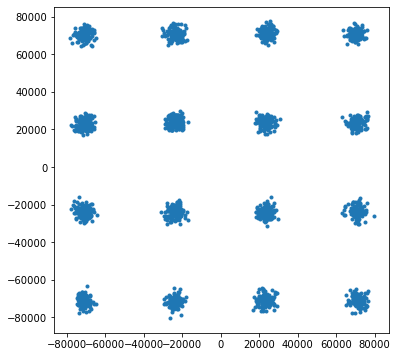

In [55]:
signal = dbp.nlc[dbp.sampling // 2::dbp.sampling]

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot()
line, = ax.plot(signal.real, signal.imag, '.')
#dbp.display_constellation(sgnl.signal['x_0'][sgnl.n//2::sgnl.n])